In [1]:
import pickle
import pandas as pd
import math
from unidecode import unidecode
import numpy as np
import scipy.io
from scipy.optimize import minimize
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

import os


from scipy.stats import linregress

PATH_VARIABLES = "./variables"
DATA_PATH = "./DatosExperimento1"

# Variables generales
ruidos = scipy.io.loadmat('ruidosExp1.mat')
ruidos = np.array(ruidos['ruidos'])
minX = np.min(ruidos[:, 2])
maxX = np.max(ruidos[:, 2])
LoopNumber = 16
numberObservations = 10

In [2]:
def normcdf2(x, mu, sigma):
    '''
    Utilizo la función norm.cdf de la librería scipy.stats para calcular la función de distribución acumulada (CDF) 
    de la distribución normal, y luego dividimos el resultado por dos y sumamos 0.5 para ajustar el rango a [0,1].
    '''
    y = (norm.cdf(x, mu, sigma) + 1) / 2
    return y

def normcdf2_minimizer(X, params):
    # X incluye mu y sigma
    mu = X[0]
    sigma = X[1]

    # x/y valores para ajustar
    x = params['x']
    y = params['y']

    # los valores ajustados con mu y sigma dados
    yfit = normcdf2(x, mu, sigma)

    # cálculo del error
    err = np.sum((yfit - y)**2)

    return err

In [3]:
luminancias = np.array([20, 20, 20, 20, 40, 40, 40, 40, 60, 60, 60, 60, 80, 80, 80, 80])
unique_luminancias = np.unique(luminancias)

colors = ['blue', 'green', 'orange', 'purple']  # Colores para los puntos y las rectas

In [4]:
mean_std_upv = np.load(PATH_VARIABLES+'/mean_std_upv.npy')
data_upv = np.load(PATH_VARIABLES+'/data_upv.npy')

mean_std_ugr = np.load(PATH_VARIABLES+'/mean_std_ugr.npy')
data_ugr = np.load(PATH_VARIABLES+'/data_ugr.npy')
 
mean_std_total = np.load(PATH_VARIABLES+'/mean_std_total.npy')
data_total = np.load(PATH_VARIABLES+'/data_total.npy')

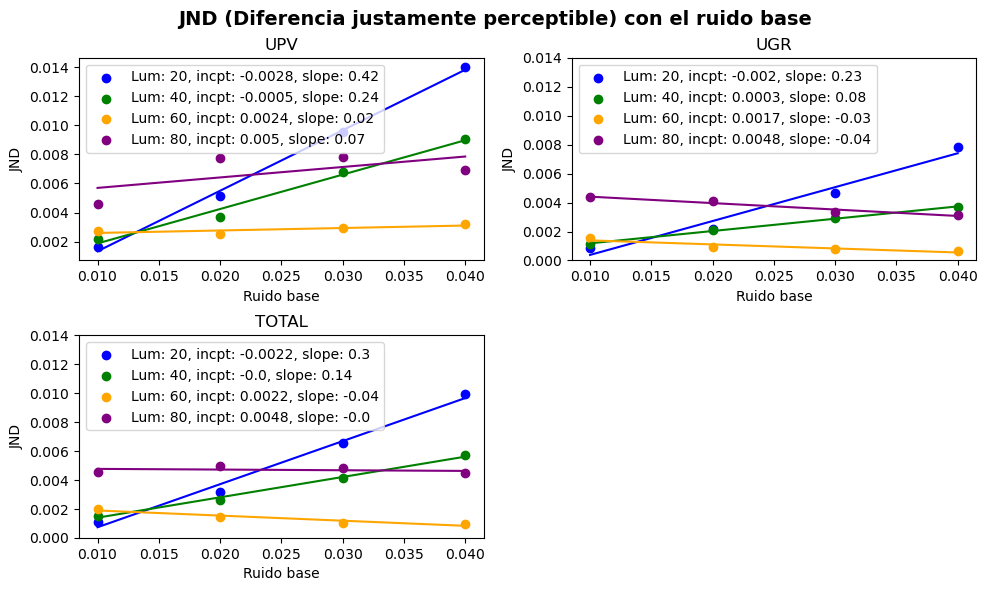

{'ugr': {20: {'intercept': -0.0019565000000000016,
   'slope': 0.23396000000000003},
  40: {'intercept': 0.00033449999999999973, 'slope': 0.08494999999999998},
  60: {'intercept': 0.0016664999999999996, 'slope': -0.02789999999999994},
  80: {'intercept': 0.004849500000000001, 'slope': -0.044410000000000054}},
 'upv': {20: {'intercept': -0.0028080000000000015,
   'slope': 0.41519000000000006},
  40: {'intercept': -0.000478000000000001, 'slope': 0.23602000000000004},
  60: {'intercept': 0.0024304999999999986, 'slope': 0.01695000000000002},
  80: {'intercept': 0.004974000000000001, 'slope': 0.07177999999999993}},
 'total': {20: {'intercept': -0.002249, 'slope': 0.2973},
  40: {'intercept': -1.800000000000022e-05, 'slope': 0.14039},
  60: {'intercept': 0.0022334999999999994, 'slope': -0.035289999999999974},
  80: {'intercept': 0.0048000000000000004, 'slope': -0.004670000000000022}}}

In [5]:
fig, axs = plt.subplots(2, 2, figsize=(10, 6))

ruido_base = np.array([i[0] for row in data_upv for i in row])
dif_u_r = np.array([i[1]-i[0] for row in data_upv for i in row])

valores_regresion_uni = {"ugr": None, "upv": None, "total": None}

for i, luminancia in enumerate(unique_luminancias):
    # Filtrar datos correspondientes a la luminancia actual
    luminancia_indices = np.where(luminancias == luminancia)
    luminancia_ruido_base = ruido_base[luminancia_indices]
    luminancia_diferencias = dif_u_r[luminancia_indices]

    # Realizar regresión lineal
    slope, intercept, r_value, p_value, std_err = linregress(luminancia_ruido_base, luminancia_diferencias)

    # Graficar los resultados
    axs[0, 0].scatter(luminancia_ruido_base, luminancia_diferencias, color=colors[i], label="Lum: {}, incpt: {}, slope: {}".format(luminancia, round(intercept,4), round(slope,2)))
    axs[0, 0].plot(luminancia_ruido_base, intercept + slope * luminancia_ruido_base, color=colors[i])
    if valores_regresion_uni["upv"] is None:
        valores_regresion_uni["upv"] = {}
    valores_regresion_uni["upv"][luminancia] = {"intercept": intercept, "slope": slope}

axs[0, 0].set_title('UPV')
axs[0, 0].set_xlabel('Ruido base')
axs[0, 0].set_ylabel('JND')
axs[0, 0].legend()

ruido_base = np.array([i[0] for row in data_ugr for i in row])
dif_u_r = np.array([i[1]-i[0] for row in data_ugr for i in row])

for i, luminancia in enumerate(unique_luminancias):
    # Filtrar datos correspondientes a la luminancia actual
    luminancia_indices = np.where(luminancias == luminancia)
    luminancia_ruido_base = ruido_base[luminancia_indices]
    luminancia_diferencias = dif_u_r[luminancia_indices]

    # Realizar regresión lineal
    slope, intercept, r_value, p_value, std_err = linregress(luminancia_ruido_base, luminancia_diferencias)

    # Graficar los resultados
    axs[0, 1].scatter(luminancia_ruido_base, luminancia_diferencias, color=colors[i], label="Lum: {}, incpt: {}, slope: {}".format(luminancia, round(intercept,4), round(slope,2)))
    axs[0, 1].plot(luminancia_ruido_base, intercept + slope * luminancia_ruido_base, color=colors[i])
    if valores_regresion_uni["ugr"] is None:
        valores_regresion_uni["ugr"] = {}
    valores_regresion_uni["ugr"][luminancia] = {"intercept": intercept, "slope": slope}

axs[0, 1].set_title('UGR')
axs[0, 1].set_xlabel('Ruido base')
axs[0, 1].set_ylabel('JND')
axs[0, 1].set_ylim([0, 0.014])
axs[0, 1].legend()

ruido_base = np.array([i[0] for row in data_total for i in row])
dif_u_r = np.array([i[1]-i[0] for row in data_total for i in row])

for i, luminancia in enumerate(unique_luminancias):
    # Filtrar datos correspondientes a la luminancia actual
    luminancia_indices = np.where(luminancias == luminancia)
    luminancia_ruido_base = ruido_base[luminancia_indices]
    luminancia_diferencias = dif_u_r[luminancia_indices]

    # Realizar regresión lineal
    slope, intercept, r_value, p_value, std_err = linregress(luminancia_ruido_base, luminancia_diferencias)

    # Graficar los resultados
    axs[1, 0].scatter(luminancia_ruido_base, luminancia_diferencias, color=colors[i], label="Lum: {}, incpt: {}, slope: {}".format(luminancia, round(intercept,4), round(slope,2)))
    axs[1, 0].plot(luminancia_ruido_base, intercept + slope * luminancia_ruido_base, color=colors[i])
    if valores_regresion_uni["total"] is None:
        valores_regresion_uni["total"] = {}
    valores_regresion_uni["total"][luminancia] = {"intercept": intercept, "slope": slope}

axs[1, 0].set_title('TOTAL')
axs[1, 0].set_xlabel('Ruido base')
axs[1, 0].set_ylabel('JND')
axs[1, 0].set_ylim([0, 0.014])
axs[1, 0].legend()

# Remover el último subplot vacío
fig.delaxes(axs[1, 1])

# Ajustar los espacios entre subplots
plt.tight_layout()

# Ajustar los espacios entre subplots
plt.subplots_adjust(top=0.9, bottom=0.1)

fig.suptitle("JND (Diferencia justamente perceptible) con el ruido base", fontsize=14, fontweight='bold')

# Mostrar la figura
plt.show()
valores_regresion_uni

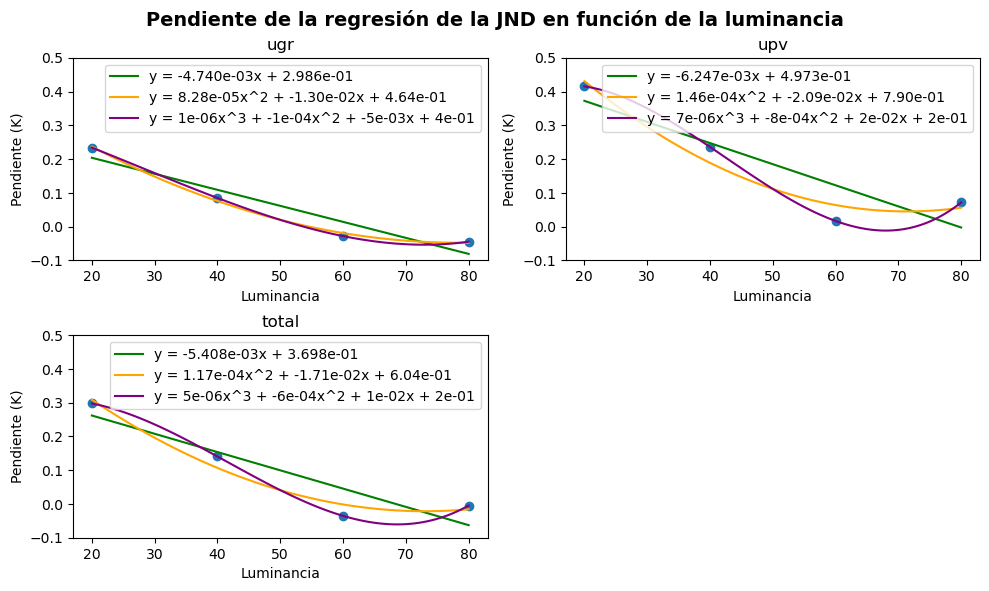

In [6]:
fig, axs = plt.subplots(2, 2, figsize=(10, 6))
count_segment = 0

for uni, valores in valores_regresion_uni.items(): 
    slope = [valores[luminancia]["slope"] for luminancia in unique_luminancias]
    x_graph = 0
    count_segment_local = count_segment
    if count_segment > 1:
        x_graph = 1
        count_segment_local = count_segment-2

    # Ajuste de regresiones
    coeffs_lineal = np.polyfit(unique_luminancias, slope, 1)
    coeffs_cuadratico = np.polyfit(unique_luminancias, slope, 2)
    coeffs_cubico = np.polyfit(unique_luminancias, slope, 3)

    x_smooth = np.linspace(unique_luminancias.min(), unique_luminancias.max(), 100)
    y_smooth_lineal = np.polyval(coeffs_lineal, x_smooth)
    y_smooth_cuadratico = np.polyval(coeffs_cuadratico, x_smooth)
    y_smooth_cubico = np.polyval(coeffs_cubico, x_smooth)

    # Fórmulas explícitas de los ajustes
        
    formula_lineal = 'y = {:.3e}x + {:.3e}'.format(coeffs_lineal[0], coeffs_lineal[1])
    formula_cuadratica = 'y = {:.2e}x^2 + {:.2e}x + {:.2e}'.format(coeffs_cuadratico[0], coeffs_cuadratico[1], coeffs_cuadratico[2])
    formula_cubica = 'y = {:.0e}x^3 + {:.0e}x^2 + {:.0e}x + {:.0e}'.format(coeffs_cubico[0], coeffs_cubico[1], coeffs_cubico[2], coeffs_cubico[3])

    axs[x_graph, count_segment_local].plot(x_smooth, y_smooth_lineal, color='green', label=formula_lineal)
    axs[x_graph, count_segment_local].plot(x_smooth, y_smooth_cuadratico, color='orange', label=formula_cuadratica)
    axs[x_graph, count_segment_local].plot(x_smooth, y_smooth_cubico, color='purple', label=formula_cubica)
    axs[x_graph, count_segment_local].scatter(unique_luminancias, slope)
    axs[x_graph, count_segment_local].set_title(f'{uni}')
    axs[x_graph, count_segment_local].set_xlabel('Luminancia')
    axs[x_graph, count_segment_local].set_ylabel('Pendiente (K)')
    axs[x_graph, count_segment_local].set_ylim([-0.1, 0.5])
    axs[x_graph, count_segment_local].legend()

    count_segment = count_segment + 1

# Eliminar subplots vacíos
fig.delaxes(axs[1, 1])

# Ajustar los espacios entre subplots
plt.tight_layout()

# Ajustar los espacios entre subplots
plt.subplots_adjust(top=0.9, bottom=0.1)

fig.suptitle(f"Pendiente de la regresión de la JND en función de la luminancia", fontsize=14, fontweight='bold')

# Mostrar la figura
plt.show()

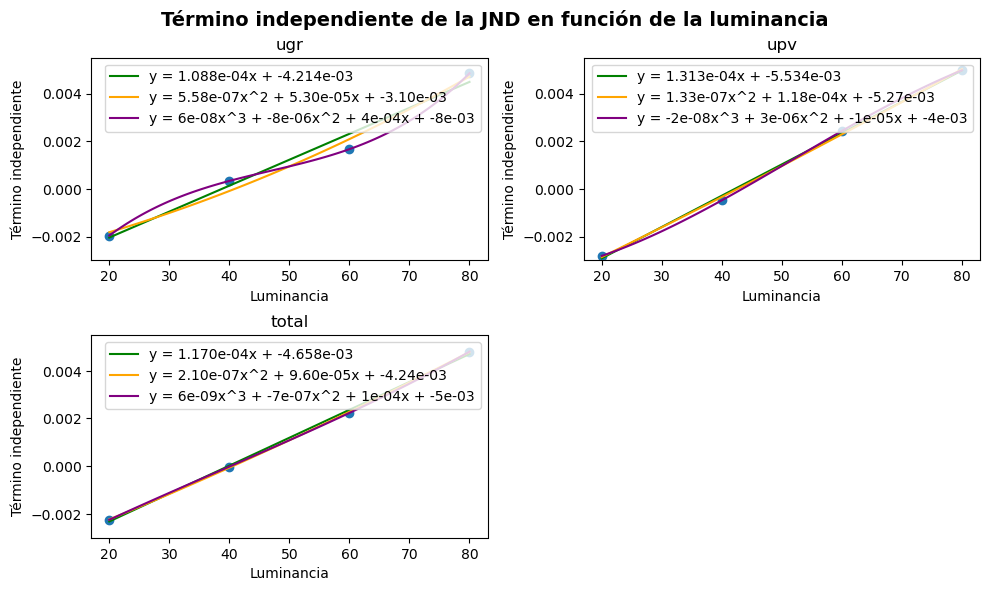

In [7]:
fig, axs = plt.subplots(2, 2, figsize=(10, 6))
count_segment = 0

for uni, valores in valores_regresion_uni.items(): 
    intercept = [valores[luminancia]["intercept"] for luminancia in unique_luminancias]
    x_graph = 0
    count_segment_local = count_segment
    if count_segment > 1:
        x_graph = 1
        count_segment_local = count_segment-2

    # Ajuste de regresiones
    coeffs_lineal = np.polyfit(unique_luminancias, intercept, 1)
    coeffs_cuadratico = np.polyfit(unique_luminancias, intercept, 2)
    coeffs_cubico = np.polyfit(unique_luminancias, intercept, 3)

    x_smooth = np.linspace(unique_luminancias.min(), unique_luminancias.max(), 100)
    y_smooth_lineal = np.polyval(coeffs_lineal, x_smooth)
    y_smooth_cuadratico = np.polyval(coeffs_cuadratico, x_smooth)
    y_smooth_cubico = np.polyval(coeffs_cubico, x_smooth)

    # Fórmulas explícitas de los ajustes        
    formula_lineal = 'y = {:.3e}x + {:.3e}'.format(coeffs_lineal[0], coeffs_lineal[1])
    formula_cuadratica = 'y = {:.2e}x^2 + {:.2e}x + {:.2e}'.format(coeffs_cuadratico[0], coeffs_cuadratico[1], coeffs_cuadratico[2])
    formula_cubica = 'y = {:.0e}x^3 + {:.0e}x^2 + {:.0e}x + {:.0e}'.format(coeffs_cubico[0], coeffs_cubico[1], coeffs_cubico[2], coeffs_cubico[3])

    axs[x_graph, count_segment_local].plot(x_smooth, y_smooth_lineal, color='green', label=formula_lineal)
    axs[x_graph, count_segment_local].plot(x_smooth, y_smooth_cuadratico, color='orange', label=formula_cuadratica)
    axs[x_graph, count_segment_local].plot(x_smooth, y_smooth_cubico, color='purple', label=formula_cubica)
    axs[x_graph, count_segment_local].scatter(unique_luminancias, intercept)
    axs[x_graph, count_segment_local].set_title(f'{uni}')
    axs[x_graph, count_segment_local].set_xlabel('Luminancia')
    axs[x_graph, count_segment_local].set_ylabel('Término independiente')
    axs[x_graph, count_segment_local].set_ylim([-0.003, 0.0055])
    axs[x_graph, count_segment_local].legend()

    count_segment = count_segment + 1

# Eliminar subplots vacíos
fig.delaxes(axs[1, 1])

# Ajustar los espacios entre subplots
plt.tight_layout()

# Ajustar los espacios entre subplots
plt.subplots_adjust(top=0.9, bottom=0.1)

fig.suptitle("Término independiente de la JND en función de la luminancia", fontsize=14, fontweight='bold')

# Mostrar la figura
plt.show()

In [8]:
# Importar el diccionario de resultados
with open(PATH_VARIABLES+"/mean_result_agrupado.pkl", 'rb') as archivo:
    mean_result_agrupado = pickle.load(archivo)
mean_result_agrupado

{'genero': {'H': array([[0.56481481, 1.85834004],
         [0.66666667, 1.94078555],
         [0.75925926, 1.87698734],
         [0.82407407, 1.75728743],
         [0.87962963, 1.64162557],
         [0.80555556, 1.49409094],
         [0.90740741, 1.36635745],
         [0.88888889, 1.55385186],
         [0.87962963, 1.36193869],
         [0.89814815, 1.29749699],
         [0.59259259, 1.9304733 ],
         [0.69444444, 1.6380961 ],
         [0.73148148, 1.55595377],
         [0.76851852, 1.81407645],
         [0.82407407, 1.45168319],
         [0.81481481, 1.45695439],
         [0.82407407, 1.50582994],
         [0.85185185, 1.31347368],
         [0.90740741, 1.34472268],
         [0.86111111, 1.34343535],
         [0.58333333, 2.15047196],
         [0.81481481, 2.14753613],
         [0.67592593, 2.00067933],
         [0.67592593, 1.85954808],
         [0.75925926, 1.61703923],
         [0.75925926, 1.72371358],
         [0.7962963 , 1.6924783 ],
         [0.86111111, 1.45409623],
     

In [9]:
luminancias = np.array([20, 20, 20, 20, 40, 40, 40, 40, 60, 60, 60, 60, 80, 80, 80, 80])
unique_luminancias = np.unique(luminancias)
unique_ruido_base = [0.01, 0.02, 0.03, 0.04]

colors = ['blue', 'green', 'orange', 'purple']  # Colores para los puntos y las rectas

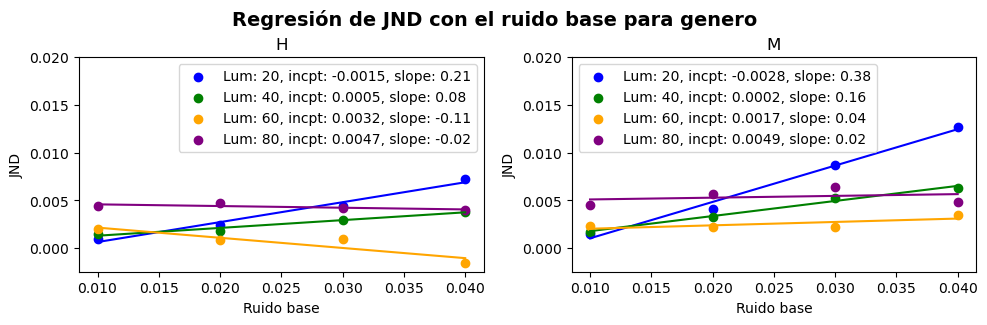

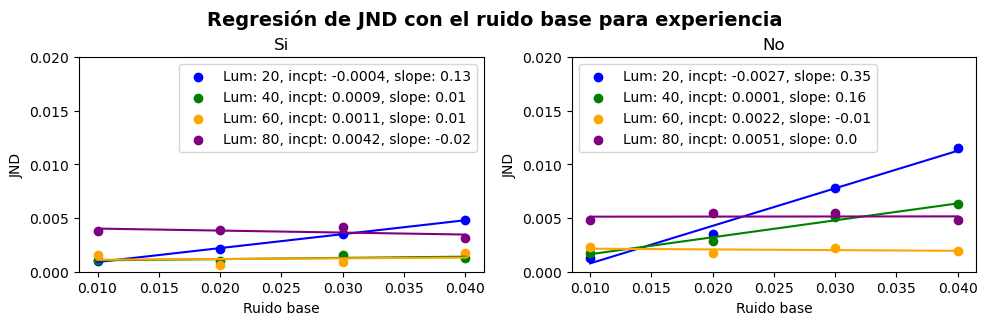

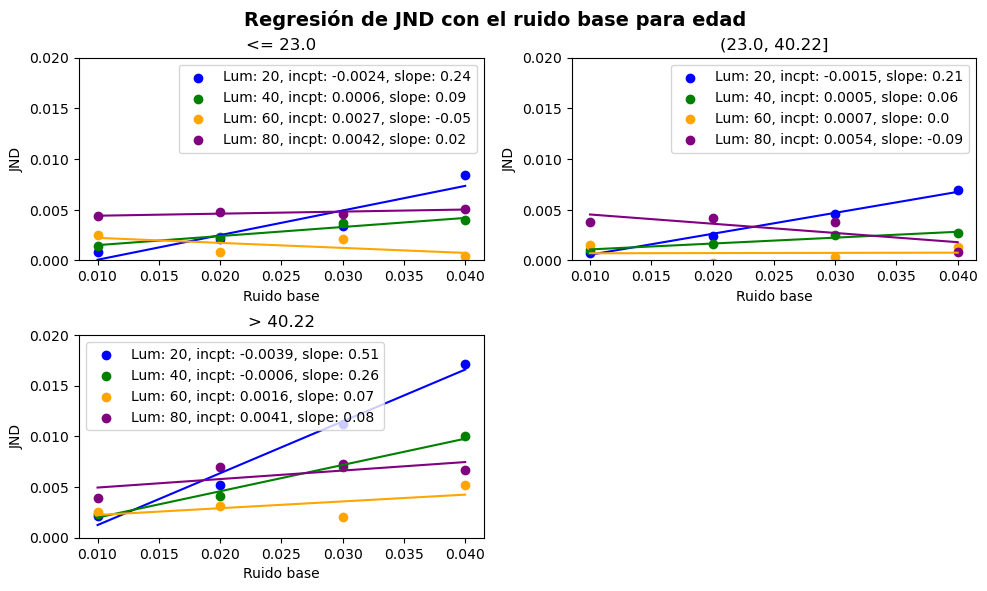

{'genero': {'H': {20: {'intercept': -0.0014760000000000016,
    'slope': 0.20892000000000008},
   40: {'intercept': 0.0004580000000000001, 'slope': 0.08177999999999994},
   60: {'intercept': 0.003192500000000001, 'slope': -0.10671000000000007},
   80: {'intercept': 0.004741, 'slope': -0.017689999999999997}},
  'M': {20: {'intercept': -0.0028085000000000002,
    'slope': 0.38136000000000003},
   40: {'intercept': 0.00017400000000000054, 'slope': 0.15821},
   60: {'intercept': 0.0016534999999999987, 'slope': 0.03551000000000007},
   80: {'intercept': 0.004892499999999999, 'slope': 0.018639999999999966}}},
 'experiencia': {'Si': {20: {'intercept': -0.0003915000000000012,
    'slope': 0.12971000000000005},
   40: {'intercept': 0.0009459999999999989, 'slope': 0.011440000000000027},
   60: {'intercept': 0.0010519999999999991, 'slope': 0.006550000000000047},
   80: {'intercept': 0.004204499999999998, 'slope': -0.018479999999999937}},
  'No': {20: {'intercept': -0.0027245000000000012,
    'slo

In [10]:
# Regresión del Incremento con el Ruido base
valores_regresion = {"genero":{"H": None, "M": None}, "experiencia":{"Si": None, "No": None}, "edad": {"<= 23.0": None, "(23.0, 40.22]":None, "> 40.22":None}}
for estadistica, grupo in mean_result_agrupado.items():
    fig, axs = plt.subplots(2, 2, figsize=(10, 6))
    count_segment = 0
    for segmento, mean_result in grupo.items():
        mean_std = []
        for i in range(LoopNumber):
            x = ruidos[i*numberObservations:(i+1)*numberObservations, 2]
            ruido_base = ruidos[i*numberObservations:(i+1)*numberObservations, 0][0]
            y = mean_result[i*numberObservations:(i+1)*numberObservations, 0]

            # Valores iniciales de la minimización
            X0 = [np.mean(x), 0.1*np.mean(x)]

            # parámetros para el ajuste
            params = {'x': x, 'y': y}

            # minimización
            ParamsOpt = minimize(normcdf2_minimizer, X0, args=params, method='Nelder-Mead').x

            # media y la desviación estándar de la distribución ajustada
            meanAndStdDistrib = [ParamsOpt[0], ParamsOpt[1]]

            mean_std.append((ruido_base, round(ParamsOpt[0], 6), round(ParamsOpt[1], 6)))
            
        data = [row for row in [mean_std[i:i+4] for i in range(0, 16, 4)]]
        ruido_base = np.array([i[0] for row in data for i in row])
        dif_u_r = np.array([i[1]-i[0] for row in data for i in row])

        for i, luminancia in enumerate(unique_luminancias):
            # Filtrar datos correspondientes a la luminancia actual
            luminancia_indices = np.where(luminancias == luminancia)
            luminancia_ruido_base = ruido_base[luminancia_indices]
            luminancia_diferencias = dif_u_r[luminancia_indices]

            # Realizar regresión lineal
            slope, intercept, r_value, p_value, std_err = linregress(luminancia_ruido_base, luminancia_diferencias)
            if valores_regresion[estadistica][segmento] is None:
                valores_regresion[estadistica][segmento] = {}
            valores_regresion[estadistica][segmento][luminancia] = {"intercept": intercept, "slope": slope}
            x_graph = 0
            count_segment_local = count_segment
            if count_segment > 1:
                x_graph = 1
                count_segment_local = count_segment-2
            # Graficar los resultados
            axs[x_graph, count_segment_local].scatter(luminancia_ruido_base, luminancia_diferencias, color=colors[i], label="Lum: {}, incpt: {}, slope: {}".format(luminancia, round(intercept,4), round(slope,2)))
            axs[x_graph, count_segment_local].plot(luminancia_ruido_base, intercept + slope * luminancia_ruido_base, color=colors[i])

            axs[x_graph, count_segment_local].set_title(f'{segmento}')
            axs[x_graph, count_segment_local].set_xlabel('Ruido base')
            axs[x_graph, count_segment_local].set_ylabel('JND')
            axs[x_graph, count_segment_local].set_ylim([0, 0.02])
            if estadistica=="genero":
                axs[x_graph, count_segment_local].set_ylim([-0.0025, 0.02])
            axs[x_graph, count_segment_local].legend()
            
        count_segment = count_segment + 1
    
    # Eliminar subplots vacíos
    if len(grupo.keys()) < 3:
        fig.delaxes(axs[1, 0])
    if len(grupo.keys()) < 4:
        fig.delaxes(axs[1, 1])
    
    # Ajustar los espacios entre subplots
    plt.tight_layout()

    # Ajustar los espacios entre subplots
    plt.subplots_adjust(top=0.9, bottom=0.1)

    fig.suptitle(f"Regresión de JND con el ruido base para {estadistica}", fontsize=14, fontweight='bold')

    # Mostrar la figura
    plt.show()
    
valores_regresion

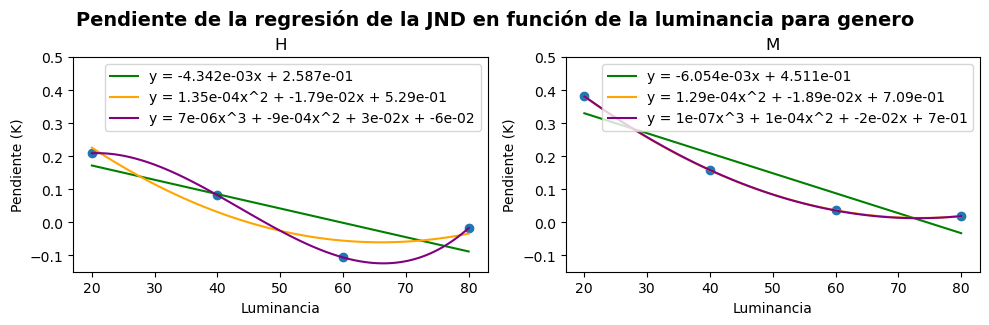

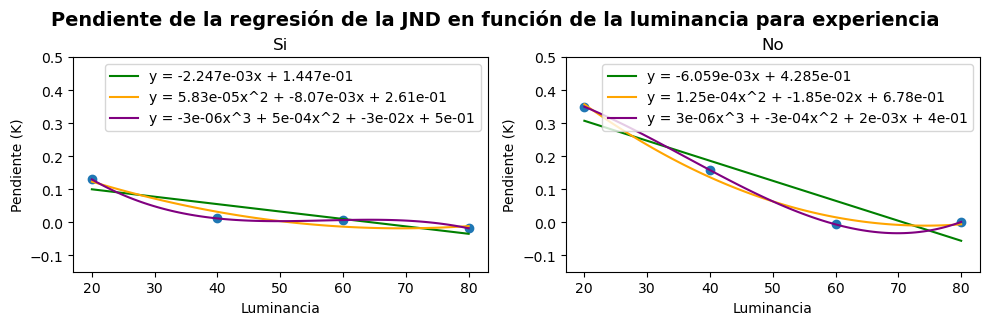

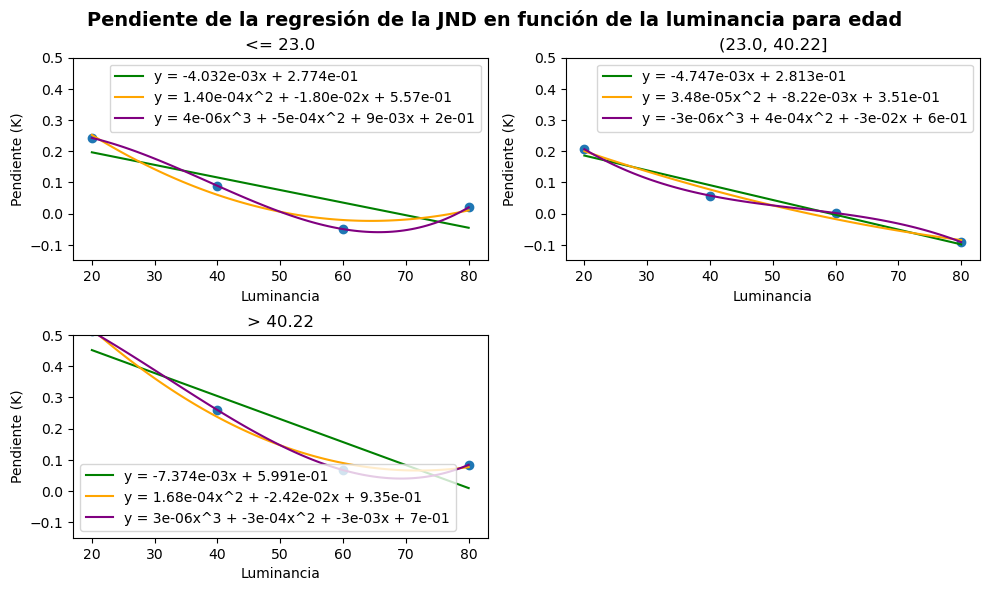

In [11]:
for estadistica, grupo in valores_regresion.items():
    fig, axs = plt.subplots(2, 2, figsize=(10, 6))
    count_segment = 0
    for segmento in grupo.keys():
        slope = [valores_regresion[estadistica][segmento][luminancia]["slope"] for luminancia in unique_luminancias]
        x_graph = 0
        count_segment_local = count_segment
        if count_segment > 1:
            x_graph = 1
            count_segment_local = count_segment-2
        
        # Ajuste de regresiones
        coeffs_lineal = np.polyfit(unique_luminancias, slope, 1)
        coeffs_cuadratico = np.polyfit(unique_luminancias, slope, 2)
        coeffs_cubico = np.polyfit(unique_luminancias, slope, 3)
        
        x_smooth = np.linspace(unique_luminancias.min(), unique_luminancias.max(), 100)
        y_smooth_lineal = np.polyval(coeffs_lineal, x_smooth)
        y_smooth_cuadratico = np.polyval(coeffs_cuadratico, x_smooth)
        y_smooth_cubico = np.polyval(coeffs_cubico, x_smooth)
        
        # Fórmulas explícitas de los ajustes        
        formula_lineal = 'y = {:.3e}x + {:.3e}'.format(coeffs_lineal[0], coeffs_lineal[1])
        formula_cuadratica = 'y = {:.2e}x^2 + {:.2e}x + {:.2e}'.format(coeffs_cuadratico[0], coeffs_cuadratico[1], coeffs_cuadratico[2])
        formula_cubica = 'y = {:.0e}x^3 + {:.0e}x^2 + {:.0e}x + {:.0e}'.format(coeffs_cubico[0], coeffs_cubico[1], coeffs_cubico[2], coeffs_cubico[3])
        
        axs[x_graph, count_segment_local].plot(x_smooth, y_smooth_lineal, color='green', label=formula_lineal)
        axs[x_graph, count_segment_local].plot(x_smooth, y_smooth_cuadratico, color='orange', label=formula_cuadratica)
        axs[x_graph, count_segment_local].plot(x_smooth, y_smooth_cubico, color='purple', label=formula_cubica)
        axs[x_graph, count_segment_local].scatter(unique_luminancias, slope)
        axs[x_graph, count_segment_local].set_title(f'{segmento}')
        axs[x_graph, count_segment_local].set_xlabel('Luminancia')
        axs[x_graph, count_segment_local].set_ylabel('Pendiente (K)')
        axs[x_graph, count_segment_local].set_ylim([-0.15, 0.5])
        axs[x_graph, count_segment_local].legend()

        count_segment = count_segment + 1
    
    # Eliminar subplots vacíos
    if len(grupo.keys()) < 3:
        fig.delaxes(axs[1, 0])
    if len(grupo.keys()) < 4:
        fig.delaxes(axs[1, 1])
    
    # Ajustar los espacios entre subplots
    plt.tight_layout()

    # Ajustar los espacios entre subplots
    plt.subplots_adjust(top=0.9, bottom=0.1)

    fig.suptitle(f"Pendiente de la regresión de la JND en función de la luminancia para {estadistica}", fontsize=14, fontweight='bold')

    # Mostrar la figura
    plt.show()

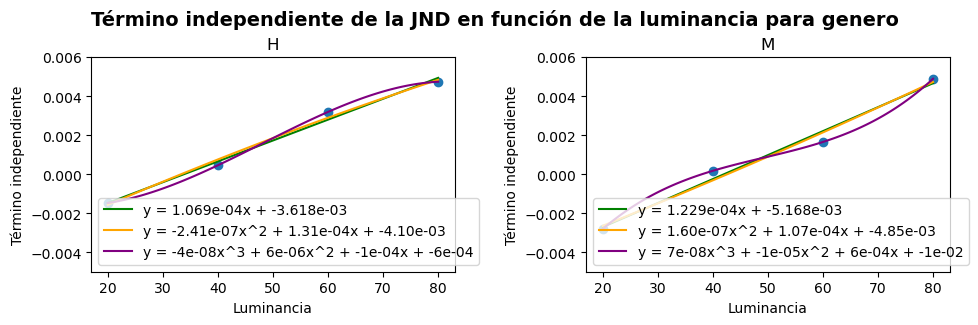

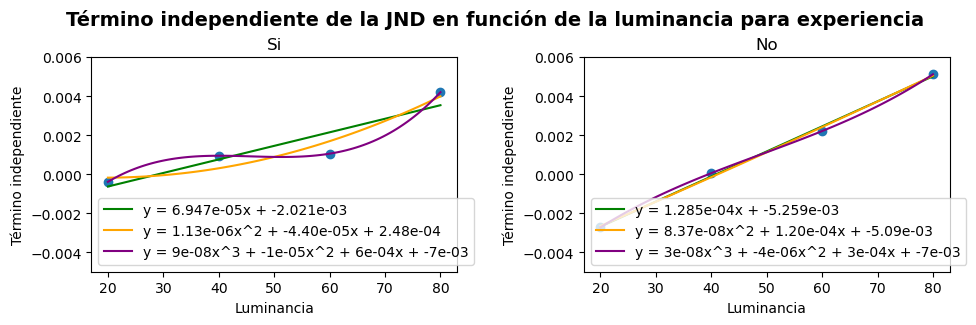

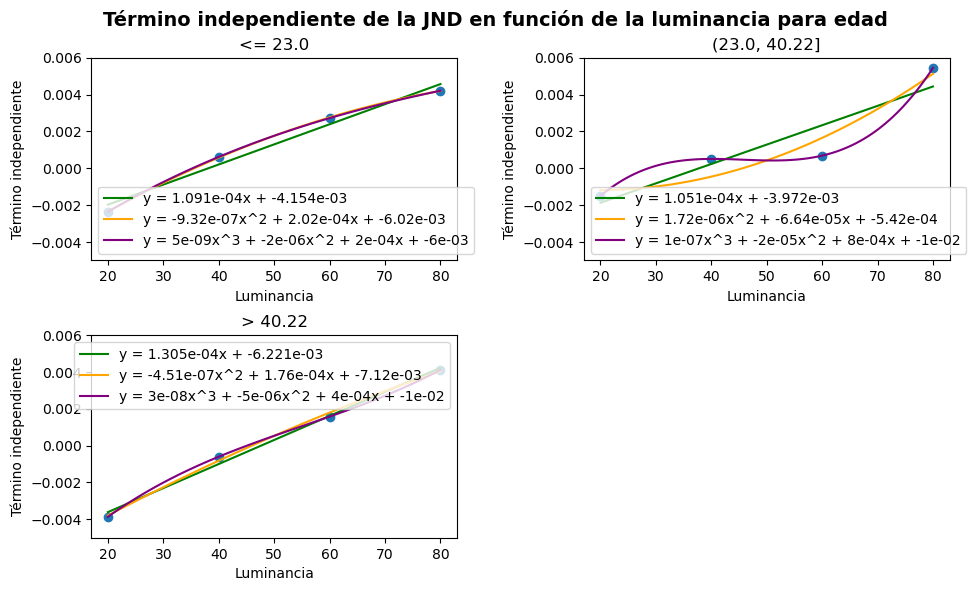

In [12]:
for estadistica, grupo in valores_regresion.items():
    fig, axs = plt.subplots(2, 2, figsize=(10, 6))
    count_segment = 0
    for segmento in grupo.keys():
        intercept = [valores_regresion[estadistica][segmento][luminancia]["intercept"] for luminancia in unique_luminancias]
        x_graph = 0
        count_segment_local = count_segment
        if count_segment > 1:
            x_graph = 1
            count_segment_local = count_segment-2
        
        # Ajuste de regresiones
        coeffs_lineal = np.polyfit(unique_luminancias, intercept, 1)
        coeffs_cuadratico = np.polyfit(unique_luminancias, intercept, 2)
        coeffs_cubico = np.polyfit(unique_luminancias, intercept, 3)
        
        x_smooth = np.linspace(unique_luminancias.min(), unique_luminancias.max(), 100)
        y_smooth_lineal = np.polyval(coeffs_lineal, x_smooth)
        y_smooth_cuadratico = np.polyval(coeffs_cuadratico, x_smooth)
        y_smooth_cubico = np.polyval(coeffs_cubico, x_smooth)
        
        # Fórmulas explícitas de los ajustes        
        formula_lineal = 'y = {:.3e}x + {:.3e}'.format(coeffs_lineal[0], coeffs_lineal[1])
        formula_cuadratica = 'y = {:.2e}x^2 + {:.2e}x + {:.2e}'.format(coeffs_cuadratico[0], coeffs_cuadratico[1], coeffs_cuadratico[2])
        formula_cubica = 'y = {:.0e}x^3 + {:.0e}x^2 + {:.0e}x + {:.0e}'.format(coeffs_cubico[0], coeffs_cubico[1], coeffs_cubico[2], coeffs_cubico[3])

        axs[x_graph, count_segment_local].plot(x_smooth, y_smooth_lineal, color='green', label=formula_lineal)
        axs[x_graph, count_segment_local].plot(x_smooth, y_smooth_cuadratico, color='orange', label=formula_cuadratica)
        axs[x_graph, count_segment_local].plot(x_smooth, y_smooth_cubico, color='purple', label=formula_cubica)
        axs[x_graph, count_segment_local].scatter(unique_luminancias, intercept)
        axs[x_graph, count_segment_local].set_title(f'{segmento}')
        axs[x_graph, count_segment_local].set_xlabel('Luminancia')
        axs[x_graph, count_segment_local].set_ylabel('Término independiente')
        axs[x_graph, count_segment_local].set_ylim([-0.005, 0.006])
        axs[x_graph, count_segment_local].legend()

        count_segment = count_segment + 1
    
    # Eliminar subplots vacíos
    if len(grupo.keys()) < 3:
        fig.delaxes(axs[1, 0])
    if len(grupo.keys()) < 4:
        fig.delaxes(axs[1, 1])
    
    # Ajustar los espacios entre subplots
    plt.tight_layout()

    # Ajustar los espacios entre subplots
    plt.subplots_adjust(top=0.9, bottom=0.1)

    fig.suptitle(f"Término independiente de la JND en función de la luminancia para {estadistica}", fontsize=14, fontweight='bold')

    # Mostrar la figura
    plt.show()